<a href="https://colab.research.google.com/github/hugueds/kaggle-titanic/blob/master/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic: Machine Learning from Disaster

## The Challenge

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

#### THE DATA


pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

##### Insights
This helps us determine, among other early insights, how representative is the training dataset of the actual problem domain.

- Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
- Survived is a categorical feature with 0 or 1 values.
- Around 38% samples survived representative of the actual survival rate at 32%.
- Most passengers (> 75%) did not travel with parents or children.
- Nearly 30% of the passengers had siblings and/or spouse aboard.
- Fares varied significantly with few passengers (<1%) paying as high as $512.
- Few elderly passengers (<1%) within age range 65-80.

#### Imports and load the data

In [1]:
%tensorflow_version 2.x
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

TensorFlow 2.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv('/content/drive/My Drive/Work/Kaggle/titanic/train.csv', index_col='PassengerId')
test = pd.read_csv('/content/drive/My Drive/Work/Kaggle/titanic/test.csv', index_col='PassengerId')

#### General information

In [4]:
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [5]:
train.shape

(891, 11)

In [6]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


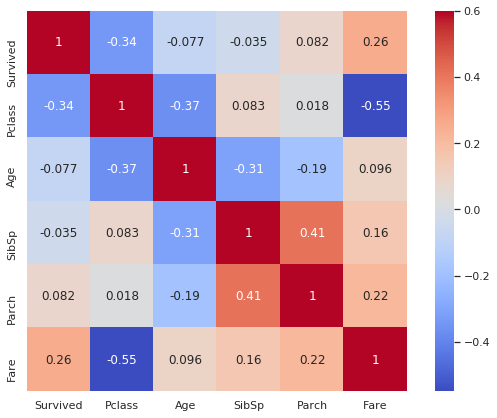

In [8]:
plt.figure(figsize=(10,7))
sns.heatmap(train.corr(), vmax=0.6, square=True, annot=True, cmap="coolwarm")

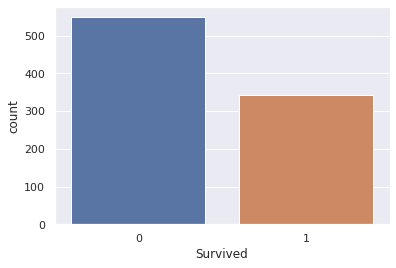

In [9]:
sns.countplot(x=train['Survived'])

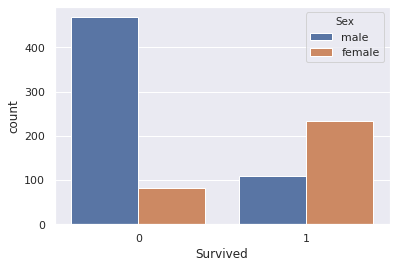

In [10]:
sns.countplot(x=train['Survived'], hue=train['Sex'])

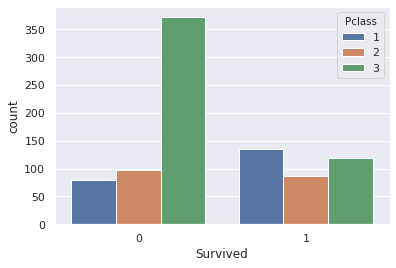

In [11]:
sns.countplot(x=train['Survived'], hue=train['Pclass'])

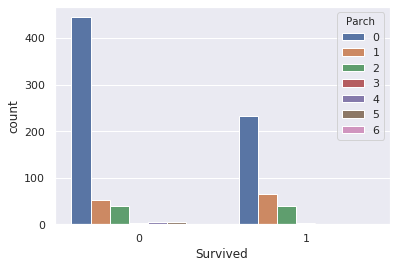

In [12]:
sns.countplot(x=train['Survived'], hue=train['Parch'])

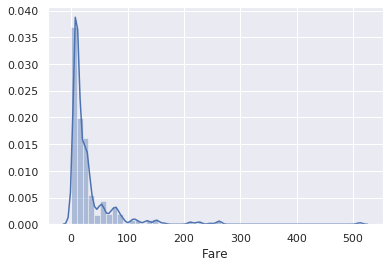

In [13]:
sns.distplot(train['Fare'])

### Processing the missing and standardize Data

 #### Insights (v.1) (not accurate)
 - Name doesn't seemed to be useful right now, however it could be useful if we know the background of the passangers
 - Cabin has a lot of missing values and doesn't seem to be useful right now, Titanic blueprints must be checked otherwise
 - Everybody has Embarked, so the missing row is meaninglass
 - Missing Ages could be replaced by ... 
 - Inspect the data inside the Ticket Column later
 - If the data doesn't have children or parents verify

#### Insights (v.2)

- Check if passager has a family
- Check if passager has an important Name
- Classify if the passager had a Cabin or not
- Fill with the most Common Embarked where the data is missing
- Do transform the ages into integers

In [0]:
# Checkpoint 
df = train.copy()
df_test = test.copy()

In [0]:
def update_embarked(data):
  highest = data['Embarked'].value_counts().index[0]
  data['Embarked'] = data['Embarked'].fillna(highest)
  return data

df = update_embarked(df)
df_test = update_embarked(df_test)

0    687
1    204
Name: HadCabin, dtype: int64
0    327
1     91
Name: HadCabin, dtype: int64


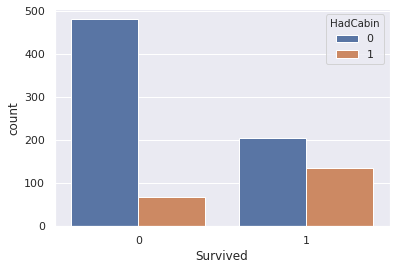

In [16]:
def get_cabin(data):
  data['HadCabin'] = data['Cabin'].notna()
  data['HadCabin'] = data['HadCabin'].astype(int)
  print(data['HadCabin'].value_counts())
  return data

df = get_cabin(df)
df_test = get_cabin(df_test)

sns.countplot(x=df['Survived'], hue=df['HadCabin'])

In [17]:
df['Fare'].median()

14.4542

In [0]:
# FARE
def classify_fare(fare):
  if fare <= 7.91:
    return 0
  elif fare > 7.91 and fare <= 14.454:
    return 1
  elif fare > 14.454 and fare <= 31:
    return 2
  elif fare > 31:
    return 3
  else:
    return 4

def update_fare(df):  
  df['Fare'] = df['Fare'].fillna(df['Fare'].median())
  df['FareCat'] = df['Fare'].apply(classify_fare)
  df['Fare'] = df['Fare'].astype(int)
  return df

df = update_fare(df)
df_test = update_fare(df_test)

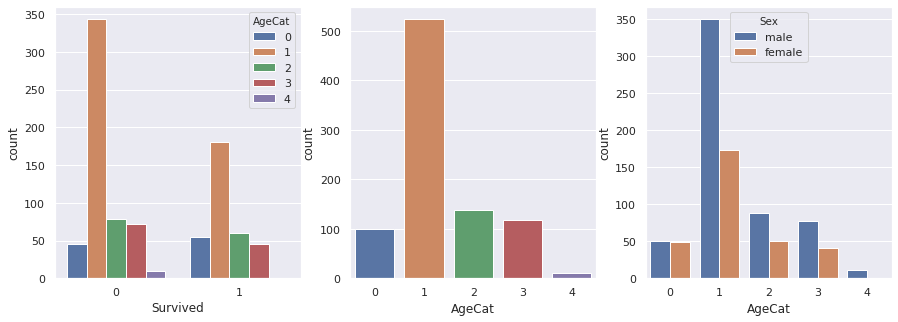

In [19]:
# AGE
def classify_age(age):    
    if age > 0 and age <= 16:
      return 0
        # return 'Young'
    elif age > 16 and age <= 32:
      return 1
    elif age > 32 and age <= 42:
      return 2
        # return 'Adult'
    elif age > 42 and age <= 64:
      return 3
        # return 'Mature'
    elif age >= 64:
      return 4
    else:
      return 2
        # return 'Old'

def update_age(df):
  df['Age'] = df['Age'].fillna(df['Age'].median())
  df['AgeCat'] = df['Age'].apply(classify_age)
  return df

df = update_age(df)
df_test = update_age(df_test)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

sns.countplot(x=df['Survived'], hue=df['AgeCat'], ax=ax1)
sns.countplot(x=df['AgeCat'], ax=ax2)
sns.countplot(x=df['AgeCat'], hue=df['Sex'], ax=ax3)

In [0]:
def update_family(df):
  df['Family'] = df['SibSp'] + df['Parch'] + 1
  df['IsAlone'] = 0
  df['IsAlone'] = df['Family'] < 2
  df['IsAlone'] = df['IsAlone'].astype(int)
  return df

df = update_family(df)
df_test = update_family(df_test)

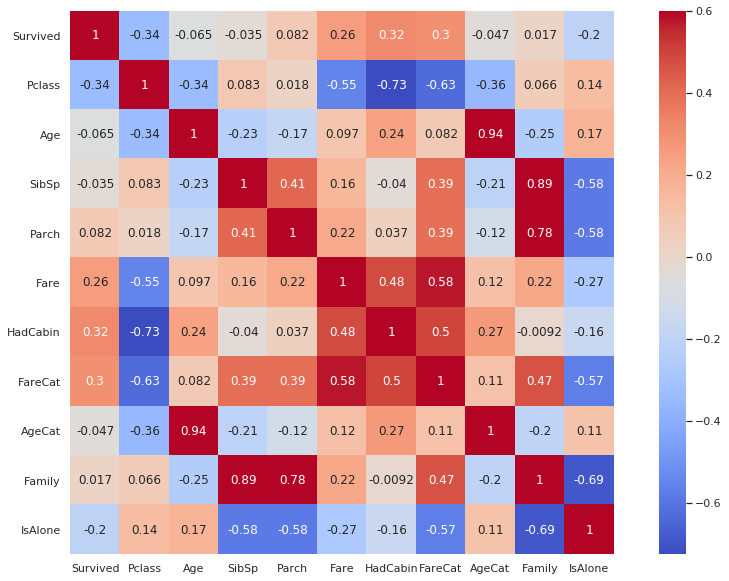

In [21]:
plt.figure(figsize=(16,10))
sns.heatmap(df.corr(), vmax=0.6, square=True, annot=True, cmap="coolwarm")

### Get the Categoricals

In [22]:
# CheckPoint
processed_df = df.copy()
processed_df_test = df_test.copy()
processed_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HadCabin,FareCat,AgeCat,Family,IsAlone
PassengerId,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7,NaN,S,0,0,1,2,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71,C85,C,1,3,2,2,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7,NaN,S,0,1,1,1,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53,C123,S,1,3,2,2,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8,NaN,S,0,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13,NaN,S,0,1,1,1,1
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30,B42,S,1,2,1,1,1
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,28.0,1,2,W./C. 6607,23,NaN,S,0,2,1,4,0


In [23]:
columns = processed_df.columns
columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'HadCabin', 'FareCat', 'AgeCat', 'Family',
       'IsAlone'],
      dtype='object')

In [24]:
def get_categoricals(df, columns):
  return pd.get_dummies(df, columns=columns, drop_first=False)

processed_df = get_categoricals(processed_df, ['Pclass', 'Sex','Embarked', 'AgeCat'])
processed_df_test = get_categoricals(processed_df_test, ['Pclass', 'Sex','Embarked', 'AgeCat'])
processed_df

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,HadCabin,FareCat,Family,IsAlone,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,AgeCat_0,AgeCat_1,AgeCat_2,AgeCat_3,AgeCat_4
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7,NaN,0,0,2,0,0,0,1,0,1,0,0,1,0,1,0,0,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71,C85,1,3,2,0,1,0,0,1,0,1,0,0,0,0,1,0,0
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7,NaN,0,1,1,1,0,0,1,1,0,0,0,1,0,1,0,0,0
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53,C123,1,3,2,0,1,0,0,1,0,0,0,1,0,0,1,0,0
5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8,NaN,0,1,1,1,0,0,1,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,"Montvila, Rev. Juozas",27.0,0,0,211536,13,NaN,0,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0
888,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30,B42,1,2,1,1,1,0,0,1,0,0,0,1,0,1,0,0,0
889,0,"Johnston, Miss. Catherine Helen ""Carrie""",28.0,1,2,W./C. 6607,23,NaN,0,2,4,0,0,0,1,1,0,0,0,1,0,1,0,0,0


In [25]:
def drop_columns(df, columns):
  for col in columns:
    df = df.drop(col, axis=1)
  return df

processed_df = drop_columns(processed_df, ['Parch','Fare','Age', 'Ticket', 'Cabin', 'Name']) # Parch?
processed_df_test = drop_columns(processed_df_test, ['Parch','Fare','Age', 'Ticket', 'Cabin', 'Name']) # Parch?
processed_df

,Survived,SibSp,HadCabin,FareCat,Family,IsAlone,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,AgeCat_0,AgeCat_1,AgeCat_2,AgeCat_3,AgeCat_4
PassengerId,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,2,0,0,0,1,0,1,0,0,1,0,1,0,0,0
2,1,1,1,3,2,0,1,0,0,1,0,1,0,0,0,0,1,0,0
3,1,0,0,1,1,1,0,0,1,1,0,0,0,1,0,1,0,0,0
4,1,1,1,3,2,0,1,0,0,1,0,0,0,1,0,0,1,0,0
5,0,0,0,1,1,1,0,0,1,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,0,0,1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,0
888,1,0,1,2,1,1,1,0,0,1,0,0,0,1,0,1,0,0,0
889,0,1,0,2,4,0,0,0,1,1,0,0,0,1,0,1,0,0,0


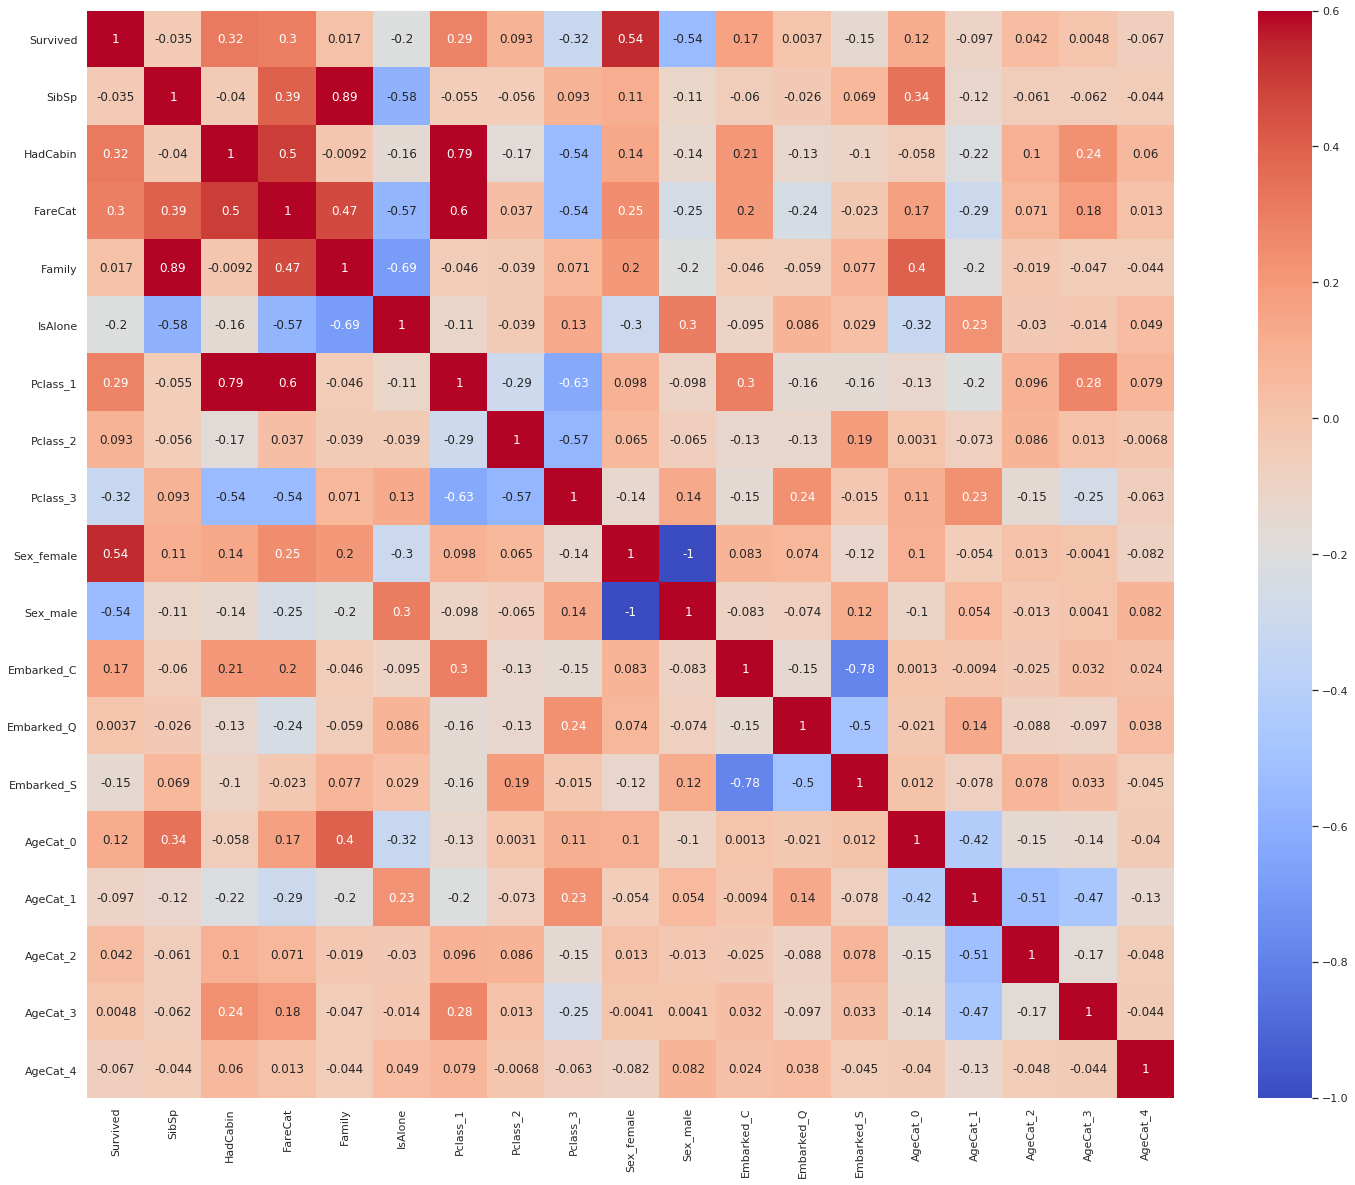

In [26]:
plt.figure(figsize=(30,20))
sns.heatmap(processed_df.corr(), vmax=0.6, square=True, annot=True, cmap="coolwarm")

#### Split the dataset

In [0]:
X = processed_df.iloc[:, 1:].values
y = processed_df.iloc[:, 0].values
X_test_pred = processed_df_test.iloc[:].values

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.80)

In [30]:
X_train.shape

(712, 18)

In [31]:
X_test.shape

(179, 18)

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()

In [0]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_test_pred = scaler.transform(X_test_pred)

#### Train the model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

In [36]:
X_train.shape

(712, 18)

In [0]:
model = Sequential()
model.add(Dense(X_train.shape[1] + 1 , activation='relu'))
model.add(Dense(X_train.shape[1] + 1 // 2 , activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')
es = EarlyStopping(patience=1)

Train on 712 samples, validate on 179 samples
Epoch 1/30
712/712 [==============================] - 0s 640us/sample - loss: 0.6835 - val_loss: 0.6704
Epoch 2/30
712/712 [==============================] - 0s 84us/sample - loss: 0.6472 - val_loss: 0.6382
Epoch 3/30
712/712 [==============================] - 0s 84us/sample - loss: 0.6230 - val_loss: 0.6039
Epoch 4/30
712/712 [==============================] - 0s 75us/sample - loss: 0.5844 - val_loss: 0.5717
Epoch 5/30
712/712 [==============================] - 0s 77us/sample - loss: 0.5531 - val_loss: 0.5377
Epoch 6/30
712/712 [==============================] - 0s 76us/sample - loss: 0.5290 - val_loss: 0.5061
Epoch 7/30
712/712 [==============================] - 0s 77us/sample - loss: 0.5063 - val_loss: 0.4790
Epoch 8/30
712/712 [==============================] - 0s 80us/sample - loss: 0.4854 - val_loss: 0.4608
Epoch 9/30
712/712 [==============================] - 0s 80us/sample - loss: 0.4895 - val_loss: 0.4504
Epoch 10/30
712/712 [=====

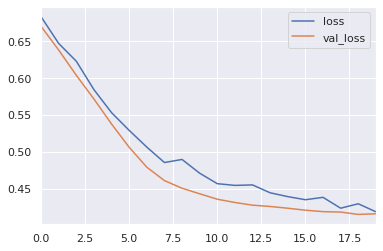

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       105
           1       0.79      0.73      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



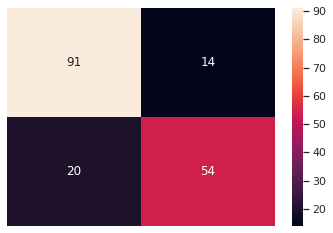

In [41]:
epochs = 30
batch_size = 1
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[es])
loss = pd.DataFrame(model.history.history)
loss.plot()
plt.show()
pred = model.predict_classes(X_test)
rep = classification_report(y_test, pred)
print(rep)

mx = confusion_matrix(y_true=y_test, y_pred=pred)
sns.heatmap(mx, annot=True, xticklabels=False, yticklabels=False)


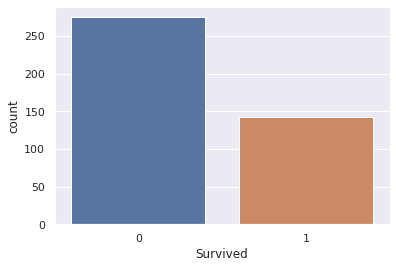

In [42]:
pred_test = model.predict_classes(X_test_pred)
d = pd.DataFrame(pred_test, columns=['Survived'])
d.index = test.index
sns.countplot(x='Survived', data=d)
d.to_csv('Survived.csv')